In [6]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy.stats import norm

import GCExitPathwayModel as GCEPM
import ExtendedModel1 as EXTM1
import ExtendedModel2 as EXTM2
import CD40Subnetwork as CDSUB

importlib.reload(GCEPM)
importlib.reload(EXTM1)
importlib.reload(EXTM2)
importlib.reload(CDSUB)

<module 'CD40Subnetwork' from 'd:\\UvA\\bioinformatics\\cell-differentiation-in-affinity-maturation-of-the-germinal-center\\CD40Subnetwork.py'>

## Basic GC-Exit Pathway Model: Heaviside & Bell curve signal

In [9]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

In [10]:
mu = np.array([mu_p, mu_b, mu_r])
sigma = np.array([sigma_p, sigma_b, sigma_r])
k = np.array([k_p, k_b, k_r])
lam = np.array([lam_p, lam_b, lam_r])

In [11]:
# Time steps
t = np.linspace(0, 100, 10000)

# Initial conditions
p0 = 0.0  # BLIMP1
b0 = 0.0  # BCL6
r0 = 0.0  # IRF4

y0 = np.array([p0, b0, r0])

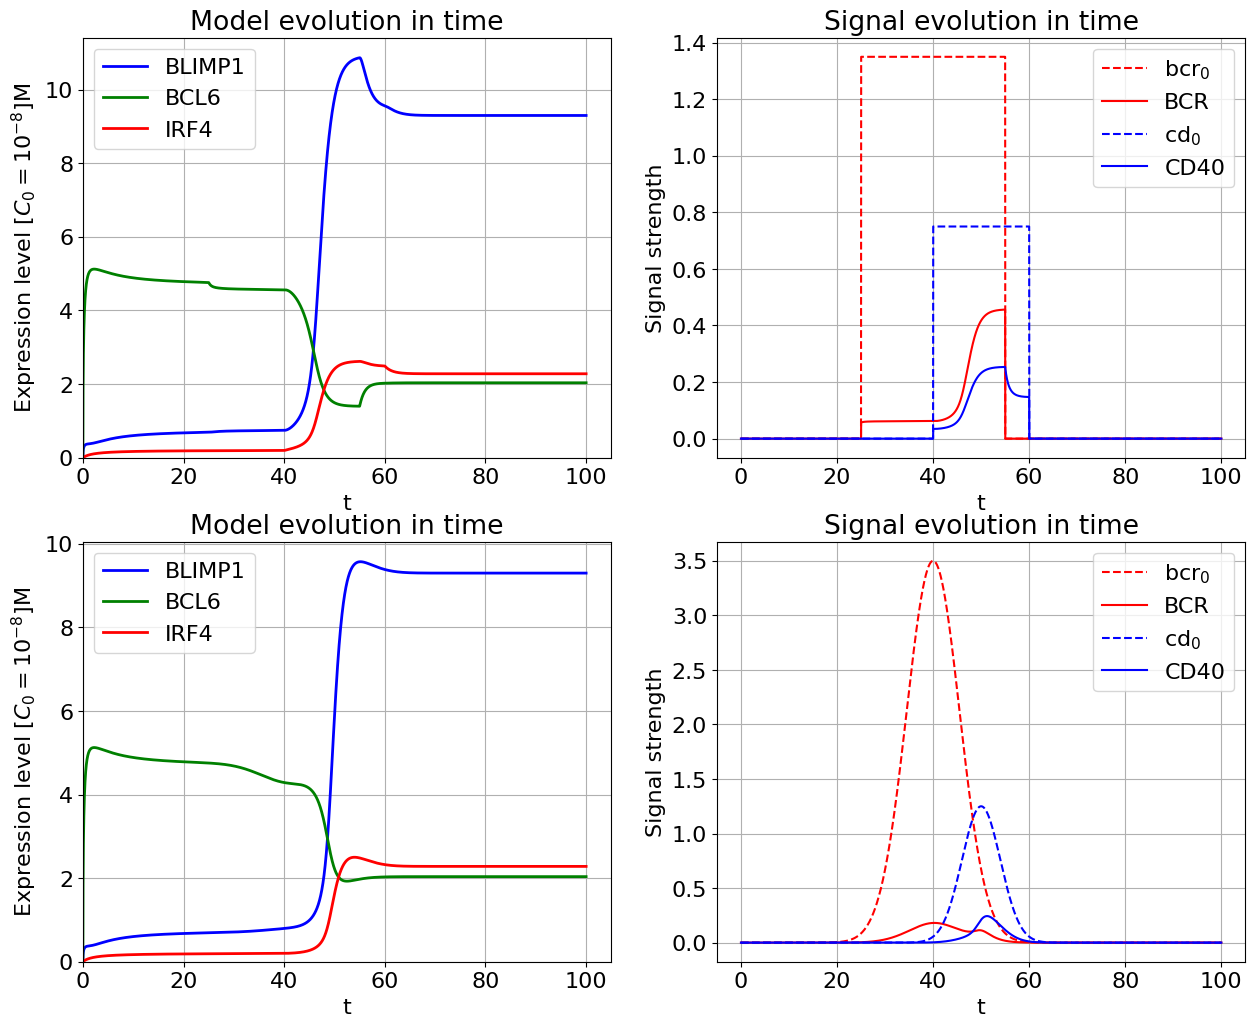

In [12]:
# Solutions and plotting
fig, ax = plt.subplots(2,2,figsize=(15,12))

# Heaviside signal
bcrt = lambda t : GCEPM.rectangle_signal(t, strength=1.35, tstart=25, tend=55)
cdt = lambda t : GCEPM.rectangle_signal(t, strength=0.75, tstart=40, tend=60)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)

GCEPM.plot_model(ax[0,0], t, sol)
GCEPM.plot_singals(ax[0,1], t, sol, k_b, bcrt, cdt)

# Bell curve signal
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=3.5, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=1.25, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)

GCEPM.plot_model(ax[1,0], t, sol)
GCEPM.plot_singals(ax[1,1], t, sol, k_b, bcrt, cdt)

## Extended Model 1: Visualization

In [13]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

# Extended model parameters
mu_x = 0.1
sigma_x = 5
k_x = 1
lam_x = 1

In [14]:
mu_basic = np.array([mu_p, mu_b, mu_r])
sigma_basic = np.array([sigma_p, sigma_b, sigma_r])
k_basic = np.array([k_p, k_b, k_r])
lam_basic = np.array([lam_p, lam_b, lam_r])

mu_extended = np.array([mu_p, mu_b, mu_r, mu_x])
sigma_extended = np.array([sigma_p, sigma_b, sigma_r, sigma_x])
k_extended = np.array([k_p, k_b, k_r, k_x])
lam_extended = np.array([lam_p, lam_b, lam_r, lam_x])

In [15]:
# Bell curve signal
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=30.0, loc=80, scale=1)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=10.0, loc=90, scale=1)

# Time steps
t = np.linspace(0, 150, 15000)

# Initial conditions
p0 = 0.0  # BLIMP1
b0 = 0.0  # BCL6
r0 = 0.0  # IRF4
x0 = 0.0  # PAX5

y0_basic = np.array([p0, b0, r0])
y0_extended = np.array([p0, b0, r0, x0])

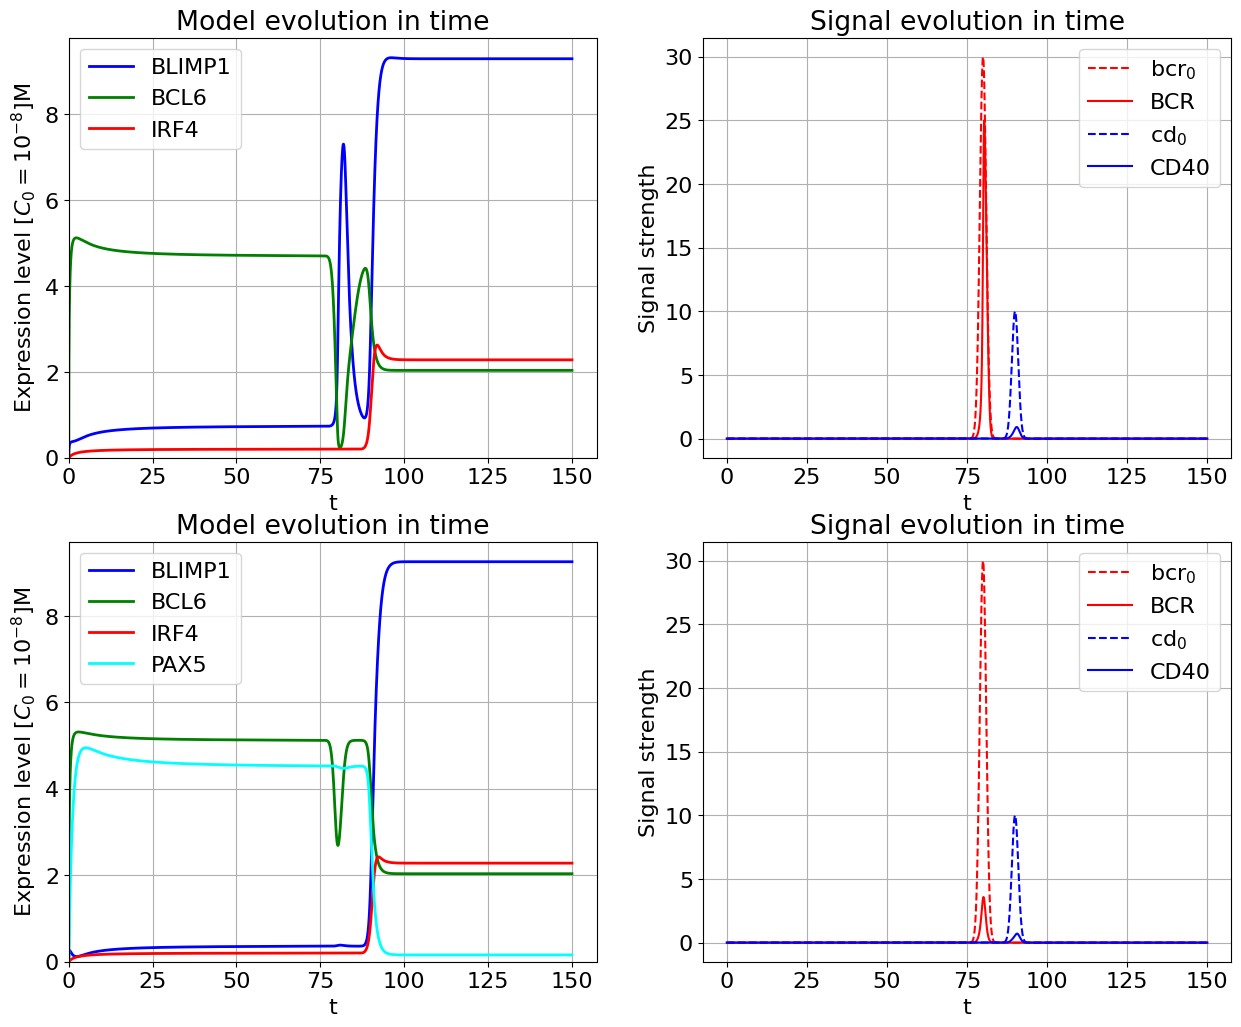

In [16]:
# Solutions and plotting
fig, ax = plt.subplots(2,2,figsize=(15,12))
sol_basic = GCEPM.solve_model(y0_basic, t, k_basic, sigma_basic, mu_basic, lam_basic, bcrt, cdt)

GCEPM.plot_model(ax[0,0], t, sol_basic)
GCEPM.plot_singals(ax[0,1], t, sol_basic, k_b, bcrt, cdt)

sol_extended = EXTM1.solve_model(y0_extended, t, k_extended, sigma_extended, mu_extended, lam_extended, bcrt, cdt)

EXTM1.plot_model(ax[1,0], t, sol_extended)
GCEPM.plot_singals(ax[1,1], t, sol_extended, k_b, bcrt, cdt)

I've changed the signals and made them much thinner, mostly because the variance of the bell curve is nowhere to be provided, so I assumed them to be normal. This yielded results closer to what can be found in the paper.

I made the signals much stronger, such that their final value (BCR, CD40) is closer to the 0-10 and 0-1 range correspondingly. The result was much more prevalent downregulation of BCL6 and upregulation of BLIMP1 when the BCR starts. 

Try BCR signal strength = 20.

## Extended Model 2: Visualization

In [17]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

# Extended model parameters
mu_x = 1
sigma_x = 3
k_x = 1
lam_x = 1

sigma_b1 = 5
sigma_b2 = 100

In [18]:
mu_basic = np.array([mu_p, mu_b, mu_r])
sigma_basic = np.array([sigma_p, sigma_b, sigma_r])
k_basic = np.array([k_p, k_b, k_r])
lam_basic = np.array([lam_p, lam_b, lam_r])

mu_extended = np.array([mu_p, mu_b, mu_r, mu_x])
sigma_extended = np.array([sigma_p, sigma_b1, sigma_b2, sigma_r, sigma_x])
k_extended = np.array([k_p, k_b, k_r, k_x])
lam_extended = np.array([lam_p, lam_b, lam_r, lam_x])

In [19]:
# Bell curve signal
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=30.0, loc=80, scale=1)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=10.0, loc=90, scale=1)

# Time steps
t = np.linspace(0, 150, 15000)

# Initial conditions
p0 = 0.0  # BLIMP1
b0 = 0.0  # BCL6
r0 = 0.0  # IRF4
x0 = 0.0  # PAX5

y0_basic = np.array([p0, b0, r0])
y0_extended = np.array([p0, b0, r0, x0])

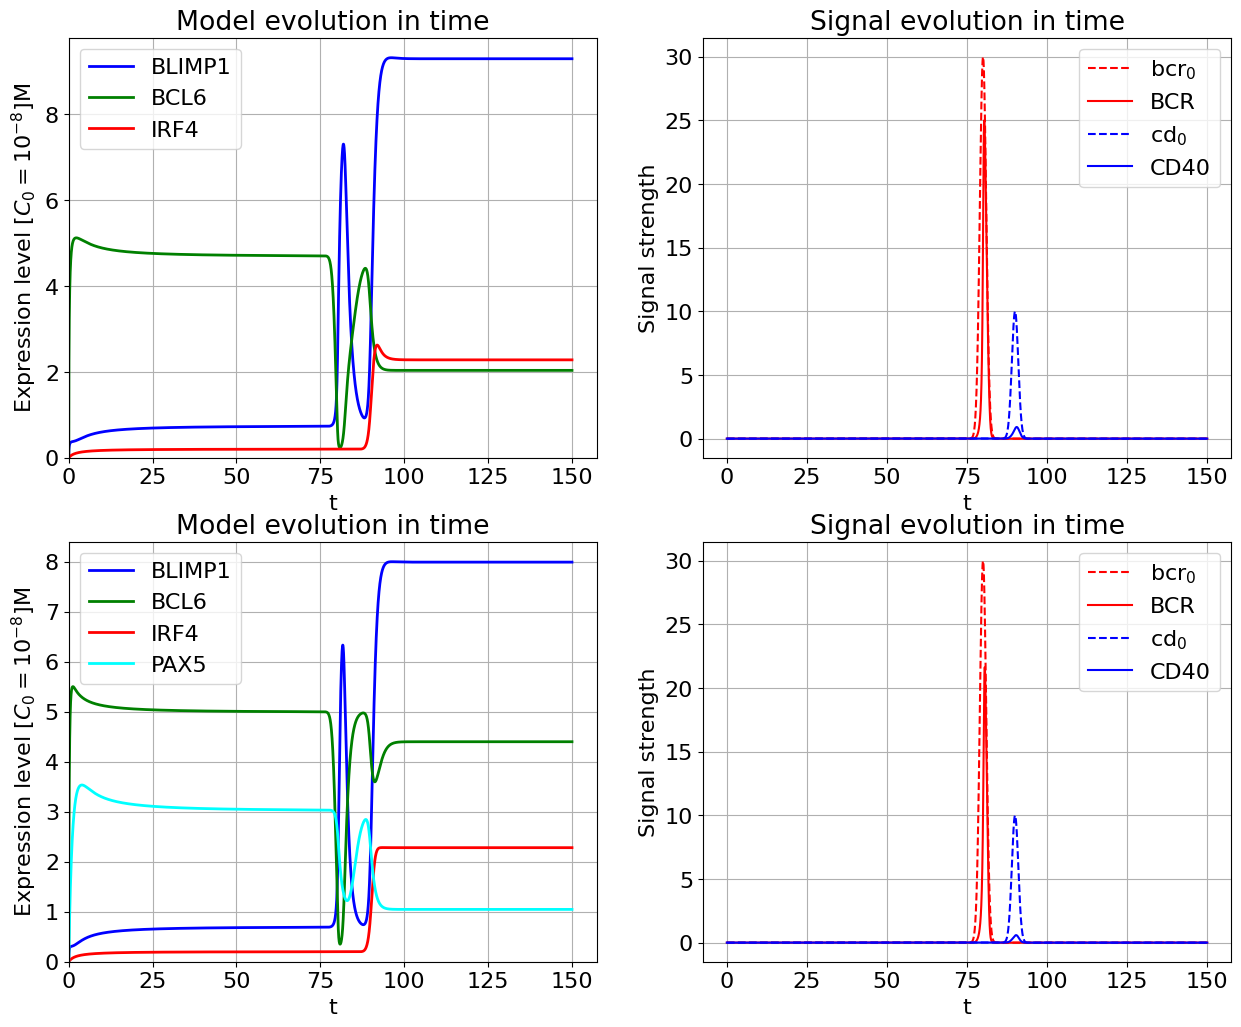

In [20]:
# Solutions and plotting
fig, ax = plt.subplots(2,2,figsize=(15,12))
sol_basic = GCEPM.solve_model(y0_basic, t, k_basic, sigma_basic, mu_basic, lam_basic, bcrt, cdt)

GCEPM.plot_model(ax[0,0], t, sol_basic)
GCEPM.plot_singals(ax[0,1], t, sol_basic, k_b, bcrt, cdt)

sol_extended = EXTM2.solve_model(y0_extended, t, k_extended, sigma_extended, mu_extended, lam_extended, bcrt, cdt)

EXTM2.plot_model(ax[1,0], t, sol_extended)
GCEPM.plot_singals(ax[1,1], t, sol_extended, k_b, bcrt, cdt)

The final result seems somewhat agreeable with the paper. In the end, BCL6 is downregulated, but at a higher level than in the baseline model. This is due to activation by PAX5. PAX5 itself is downregulated by the BLIMP1 during the "spike" phase. Spike flattening that can be observed in the paper is unfortunately not observed.

## BCR Subnetwork steady-state analysis

The dynamical equations of the baseline model are reduced to:

$$
\begin{align}
\text{BLIMP1}: \;\;\; & \frac{dp}{dt} = \mu_p + \sigma_p \frac{k_b^2}{k_b^2 + b^2} - \lambda_p p \\
\text{BCL6}: \;\;\; & \frac{db}{dt} = \mu_{b} + \sigma_{b} \frac{k_p^2}{k_p^2 + p^2} \cdot \frac{k_b^2}{k_b^2 + b^2} - (\lambda_b + bcr_0 \frac{k_b^2}{k_b^2 + b^2}) b \\
\end{align}
$$

Setting both $\frac{dp}{dt}, \frac{db}{dt}$ to $0$ and rewriting $p$ (BLIMP1) in terms of $b$ (BCL6) yields nullclines as below. We substitute a constant value for $bcr_0$.

$$
\begin{align}
p(b) \mid_{\frac{dp}{dt} = 0} &= \frac{\mu_p + \sigma_p \frac{k_b^2}{k_b^2 + b^2}}{\lambda_p} \\
p(b) \mid_{\frac{db}{dt} = 0} &= \sqrt{\frac{\sigma_b k_p^2 k_b^2}{(k_b^2 + b^2) \left[ (\lambda_b + bcr_0 \frac{k_b^2}{k_b^2 + b^2}) b - \mu_b\right]} - k_p^2} = \\
\end{align}
$$

In [69]:
# BLIMP1 nullcline as given in the equation above
def dpdt_nullcline(b, kb, mp, sp, lp):
    return (mp + sp * ((kb**2) / (kb**2 + b**2))) / lp

# BCL6 nullcline as given in the equation above
def dbdt_nullcline(b,  kb, kp, mb, sb, lb, bcr0):
    BCR = bcr0 * ((kb**2) / (kb**2 + b**2))
    return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)

In [22]:
plt.rcParams.update({'font.size': 18})

C:\Users\User23718901\AppData\Local\Temp\ipykernel_18980\2921402822.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)


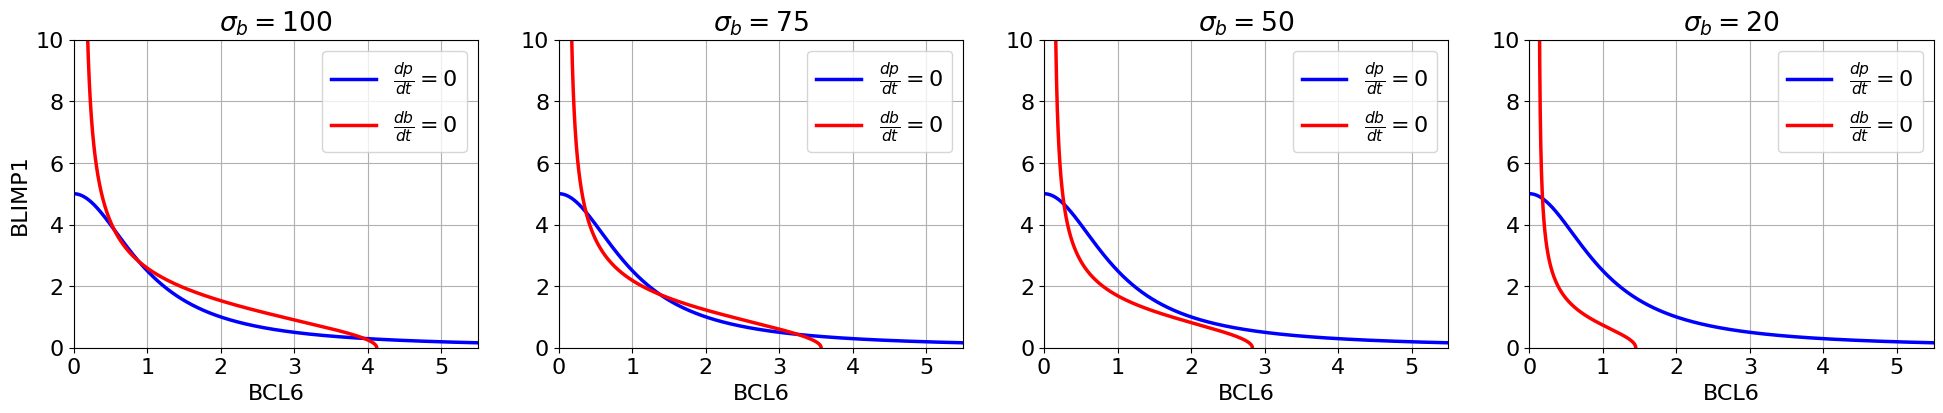

In [71]:
bs = np.linspace(0, 5.5, 10000)

# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2

sigma_p = 5

k_p = 1
k_b = 1

lam_p = 1
lam_b = 1

# The paper claims that the system becomes bistable under the condition that sigma_b / lambda_b = 20.
# This seems not to be the case and we verify it by plotting nullclines for different values of sigma_b while keeping lambda_b constant.
sigma_bs = [100, 75, 50, 20]

# Plotting
fig, axes = plt.subplots(1,4,figsize=(24,4))
axes[0].set_ylabel("BLIMP1")

for sigma_b, ax in zip(sigma_bs, axes.flatten()):
    dpdt = dpdt_nullcline(bs, k_b, mu_p, sigma_p, lam_p)
    dbdt = dbdt_nullcline(bs, k_b, k_p, mu_b, sigma_b, lam_b, 15)

    ax.plot(bs, dpdt, color="blue", label=r"$\frac{dp}{dt} = 0$", lw=2.5)
    ax.plot(bs, dbdt, color="red", label=r"$\frac{db}{dt} = 0$", lw=2.5)

    ax.set_xlabel("BCL6")
    ax.set_title(r"$\sigma_b = $" + f"{sigma_b}")

    ax.set_ylim(0, 10)
    ax.set_xlim(0, 5.5)

    ax.grid()
    ax.legend()

plt.show()

Figure S1 is reproducible with the shape of the nullclines and three critical points as described in the paper. However, there seems to be a sort of discrepancy as to bistability condition. The paper claims that the system becomes bistable when $\sigma_b / \lambda_b \gt 20$. However, above plots seem to contradict this statement. When the analytically derived nullclines are plotted for fixed $\lambda_b = 1$ and varying $\sigma_b$, it seems like the nullclines start to intersect at only a single point already at a threshold of $\sigma_b / \lambda_b \lt 50$, but it also depends on other parameter values.

Perhaps what this bistability condition means is that when $\sigma_b / \lambda_b \gt 20$, the $BCR$ value can be adjusted such that the bistability occurs. For the plots above, rightmost ($\sigma_b = 20$) plot becomes bistable at around $bcr_0 = 5$. This is the important note: to recreate these plots, $bcr_0$ was set to $15$, rather than $BCR$ itself as the paper suggests.

**QUESTION:** I tried obtaining this exact threshold value through calculating Jacobian matrix:

$$ \huge \mathbf{J} = \begin{bmatrix} \frac{d \frac{dp}{dt}}{dp} & & \frac{d \frac{dp}{dt}}{db} \\ \\ \frac{d \frac{db}{dt}}{dp} & & \frac{d \frac{db}{dt}}{db} \end{bmatrix} $$

and then perhaps solving for the eigenvalues of $\mathbf{J}$ by calculating the solutions to characteristic equation. Is that a good approach ?

## (Ir)reversibility of changes in gene expression levels due to BCR-CD40 cosignalling

In [24]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

In [25]:
mu = np.array([mu_p, mu_b, mu_r])
sigma = np.array([sigma_p, sigma_b, sigma_r])
k = np.array([k_p, k_b, k_r])
lam = np.array([lam_p, lam_b, lam_r])

In [26]:
# Time steps
t = np.linspace(0, 100, 10000)

# Initial conditions
p0 = 0.0  # BLIMP1
b0 = 0.0  # BCL6
r0 = 0.0  # IRF4

y0 = np.array([p0, b0, r0])

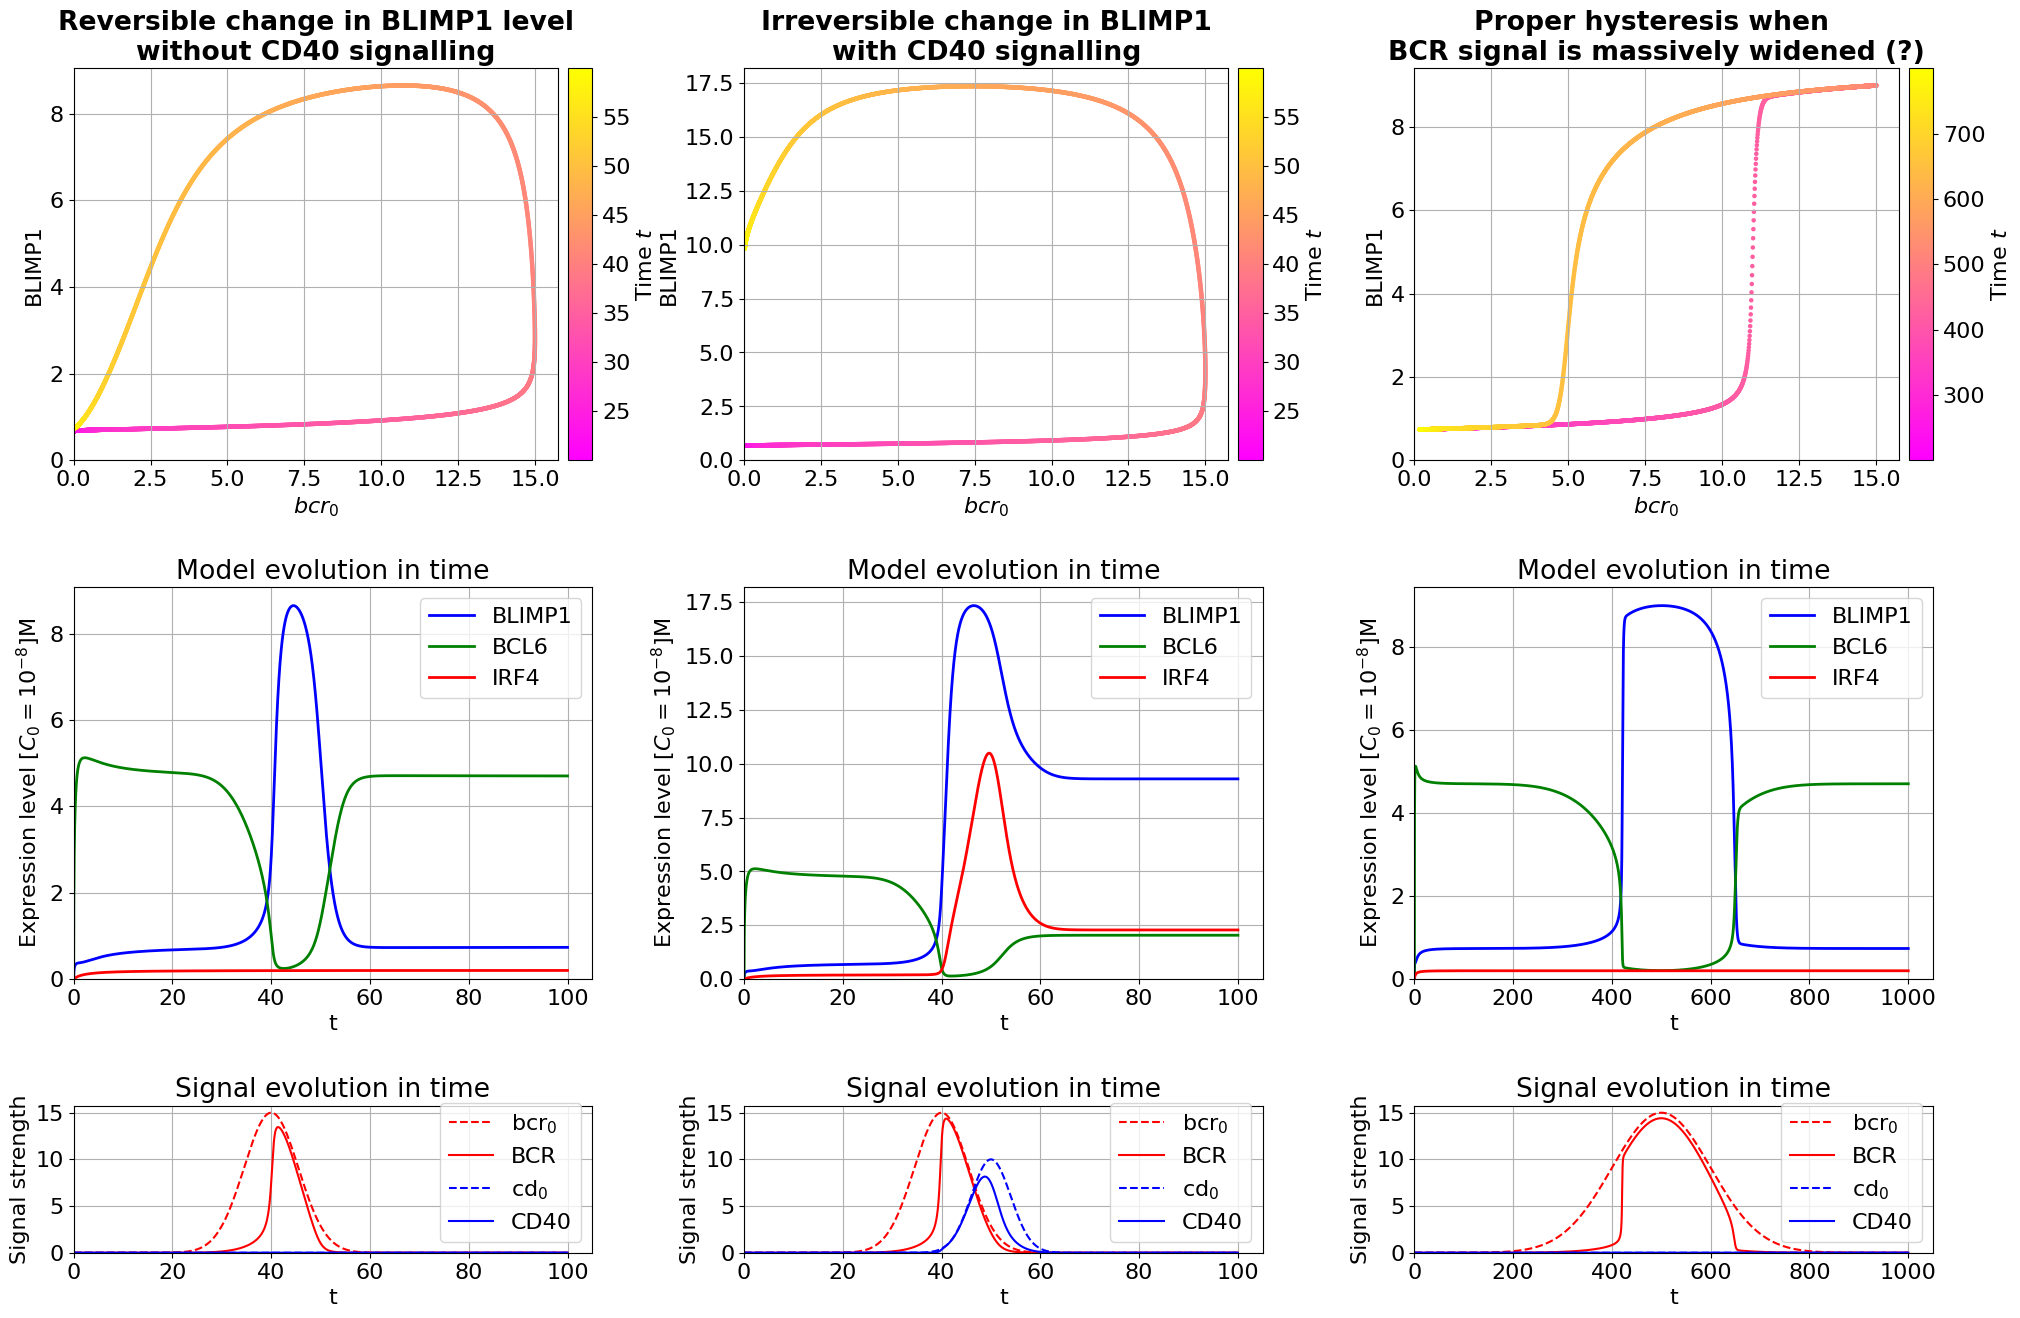

In [27]:
plt.rcParams.update({'font.size': 16})

# Solutions and plotting
fig, ax = plt.subplots(3,3,figsize=(21,14),height_ratios=[2,2,0.75])
fig.tight_layout(pad=4.0)

# --- Case 1: No CD40 signalling, reversible behaviour ---
t = np.linspace(0, 100, 10000)
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
p, b = sol[:,0], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,0].scatter(bcr0[2000:-4000], p[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,0].grid()
ax[0,0].set_xlabel(r"$bcr_0$")
ax[0,0].set_ylabel("BLIMP1")
ax[0,0].set_xlim(0,)
ax[0,0].set_ylim(0,)
ax[0,0].set_title("Reversible change in BLIMP1 level\nwithout CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,0], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,0], t, sol, k_b, bcrt, cdt)
ax[2,0].set_ylim(0,)
ax[2,0].set_xlim(0,)
ax[2,0].set_yticks([0,5,10,15])

# --- Case 2: With CD40 signalling, irreversible behaviour ---
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=10, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
p, b = sol[:,0], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,1].scatter(bcr0[2000:-4000], p[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,1].grid()
ax[0,1].set_xlabel(r"$bcr_0$")
ax[0,1].set_ylabel("BLIMP1")
ax[0,1].set_xlim(0,)
ax[0,1].set_ylim(0,)
ax[0,1].set_title("Irreversible change in BLIMP1\nwith CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,1], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,1], t, sol, k_b, bcrt, cdt)
ax[2,1].set_xlim(0,)
ax[2,1].set_ylim(0,)
ax[2,1].set_yticks([0,5,10,15])

# --- Case 3: Proper hysteresis (?) ---
t = np.linspace(0, 1000, 10000)

bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=500, scale=100)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
p, b = sol[:,0], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,2].scatter(bcr0[2000:-2000], p[2000:-2000], s=5, c=t[2000:-2000], cmap="spring")
ax[0,2].grid()
ax[0,2].set_xlabel(r"$bcr_0$")
ax[0,2].set_ylabel("BLIMP1")
ax[0,2].set_xlim(0,)
ax[0,2].set_ylim(0,)
ax[0,2].set_title("Proper hysteresis when \nBCR signal is massively widened (?)", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,2], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,2], t, sol, k_b, bcrt, cdt)
ax[2,2].set_ylim(0,)
ax[2,2].set_xlim(0,)
ax[2,2].set_yticks([0,5,10,15])

plt.show()

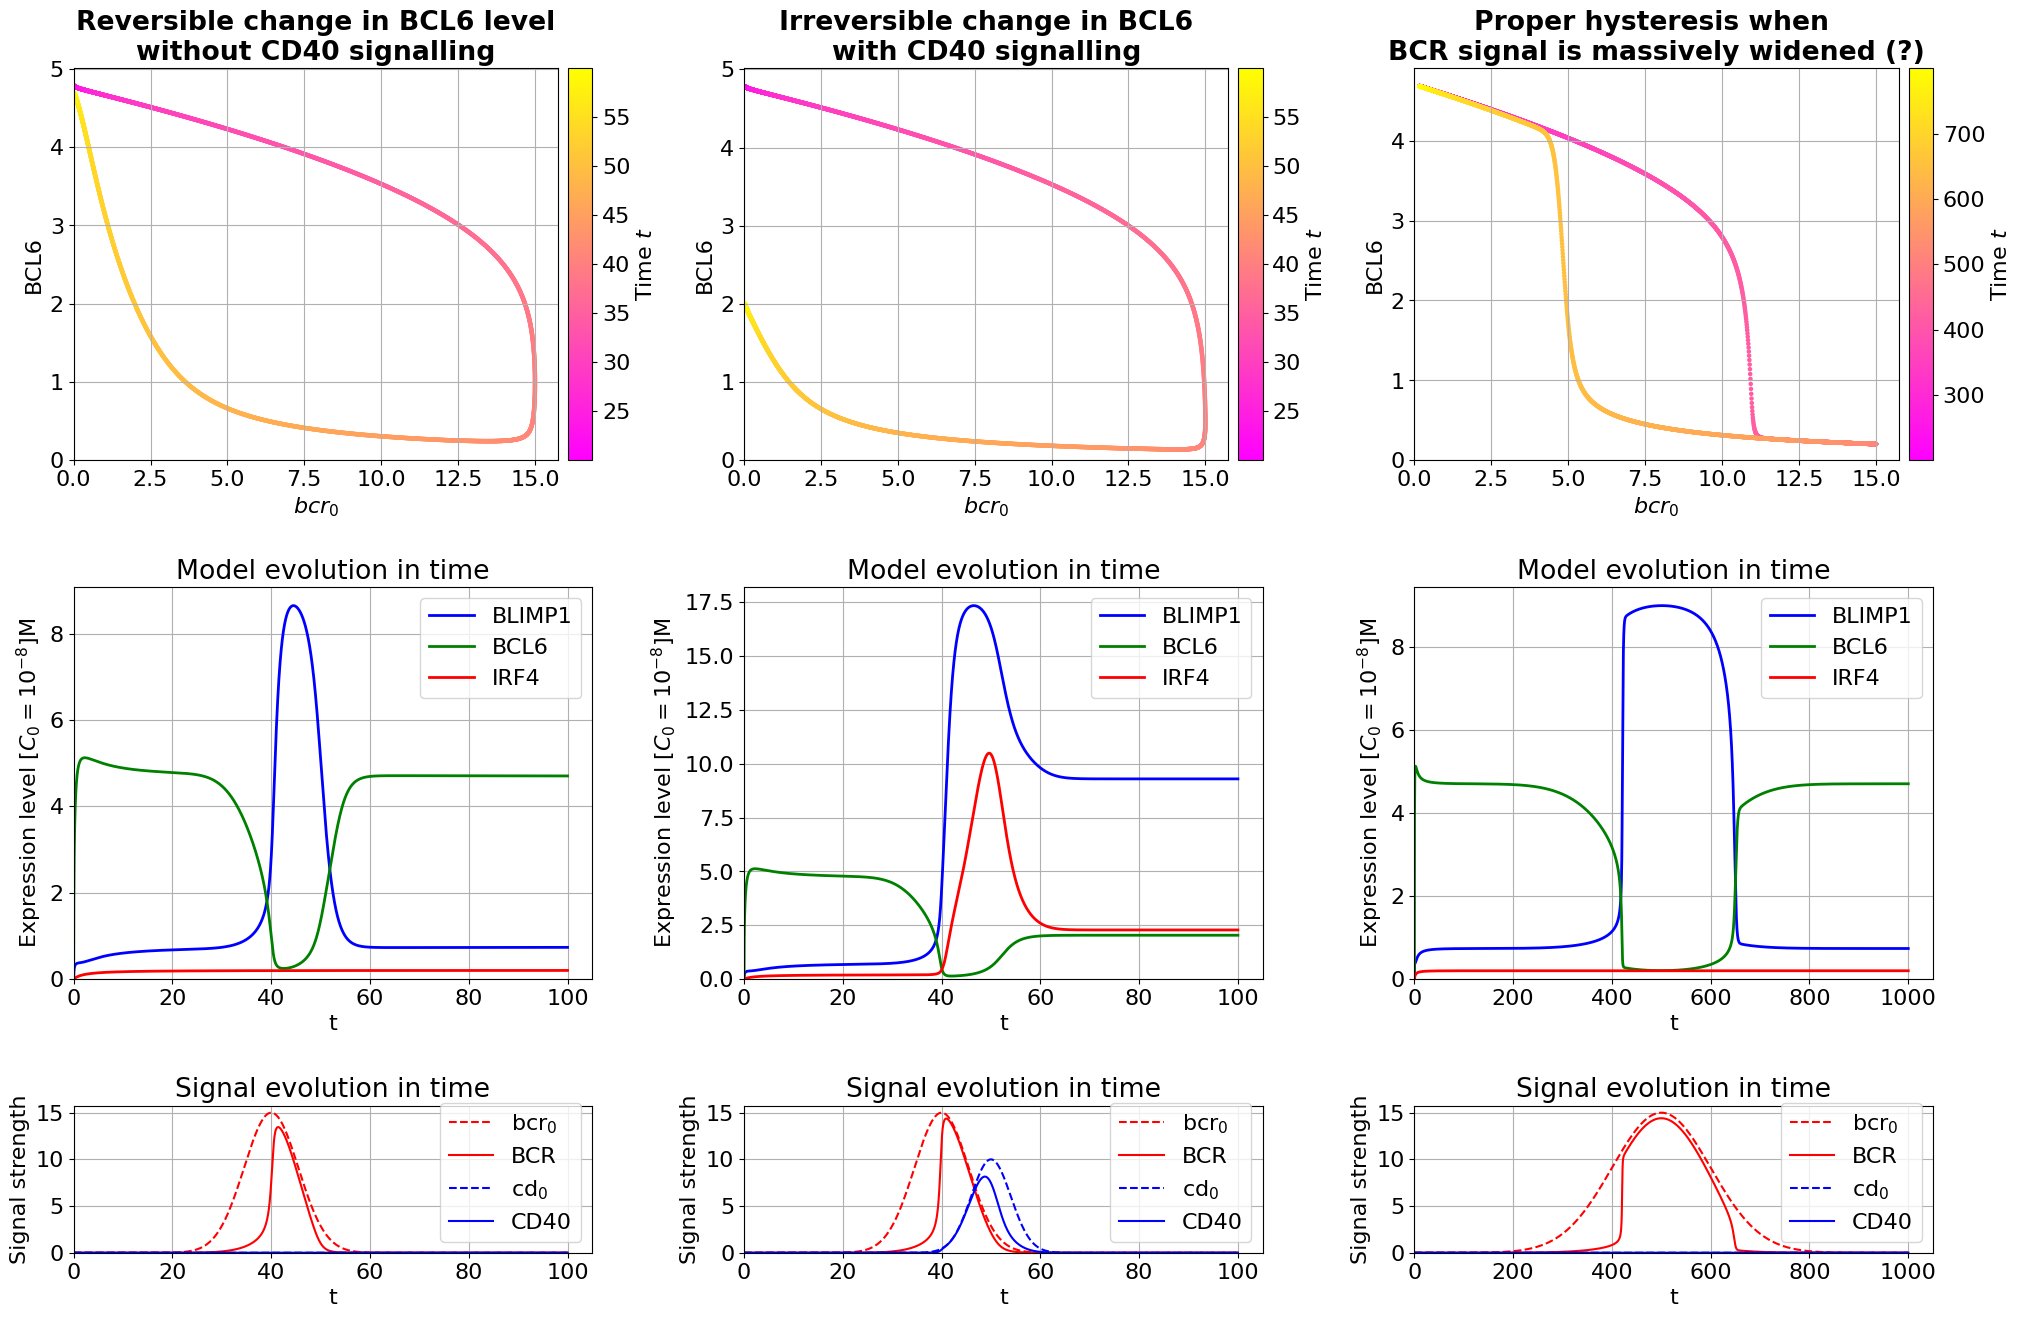

In [28]:
plt.rcParams.update({'font.size': 16})

# Solutions and plotting
fig, ax = plt.subplots(3,3,figsize=(21,14),height_ratios=[2,2,0.75])
fig.tight_layout(pad=4.0)

# --- Case 1: No CD40 signalling, reversible behaviour ---
t = np.linspace(0, 100, 10000)
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
b = sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,0].scatter(bcr0[2000:-4000], b[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,0].grid()
ax[0,0].set_xlabel(r"$bcr_0$")
ax[0,0].set_ylabel("BCL6")
ax[0,0].set_xlim(0,)
ax[0,0].set_ylim(0,)
ax[0,0].set_title("Reversible change in BCL6 level\nwithout CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,0], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,0], t, sol, k_b, bcrt, cdt)
ax[2,0].set_ylim(0,)
ax[2,0].set_xlim(0,)
ax[2,0].set_yticks([0,5,10,15])

# --- Case 2: With CD40 signalling, irreversible behaviour ---
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=10, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
b = sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,1].scatter(bcr0[2000:-4000], b[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,1].grid()
ax[0,1].set_xlabel(r"$bcr_0$")
ax[0,1].set_ylabel("BCL6")
ax[0,1].set_xlim(0,)
ax[0,1].set_ylim(0,)
ax[0,1].set_title("Irreversible change in BCL6\nwith CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,1], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,1], t, sol, k_b, bcrt, cdt)
ax[2,1].set_xlim(0,)
ax[2,1].set_ylim(0,)
ax[2,1].set_yticks([0,5,10,15])

# --- Case 3: Proper hysteresis (?) ---
t = np.linspace(0, 1000, 10000)

bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=500, scale=100)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
b = sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,2].scatter(bcr0[2000:-2000], b[2000:-2000], s=5, c=t[2000:-2000], cmap="spring")
ax[0,2].grid()
ax[0,2].set_xlabel(r"$bcr_0$")
ax[0,2].set_ylabel("BCL6")
ax[0,2].set_xlim(0,)
ax[0,2].set_ylim(0,)
ax[0,2].set_title("Proper hysteresis when \nBCR signal is massively widened (?)", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,2], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,2], t, sol, k_b, bcrt, cdt)
ax[2,2].set_ylim(0,)
ax[2,2].set_xlim(0,)
ax[2,2].set_yticks([0,5,10,15])

plt.show()

**TODO:** for the hysteresis curve, for a given $bcr_0 (BCR)$, try to find all roots $BCL6$ given the derivatives are $0$ (stable state) and see if you can retrieve hysteresis curve (right column).

The plots above were created for parameters as given in table S1 and show (ir)reversebility of changes in expression level due to cosignalling of BCR and CD40 as well as hysteretic behaviour for both BCL6 and BLIMP1.

* **Rows:**
  * Top row shows genetic expression level changing as the signalling rises and ceases
  * Center row shows corresponding model dynamics
  * Bottom row shows signal levels for both the BCR signalling (red lines) and CD40 signalling (blue lines):
    * Dashed line shows bell curve signal without the BCL6 repression
    * Regular line shows the final signal after taking the repression into account

* **Columns:**
  * Left column shows reversible change in expression level when only BCR signal is active (no cosignalling)
  * Center column shows irreversible change in expression level when both BCR and CD40 signals are active (cosignalling)
  * Right column shows (proper) hysteretic behaviour when the signal as well as the time scale is heavily widened
  
A key change made to the plots to actually show the hysteresis was the $x$-axis. The expression levels are plotted against $bcr_0$ (unrepressed signal) and not against $BCR$ (repressed by BCL6) as the paper suggests. The model is still ran with the repression included. Does this make sense ? Yes, it does. Assuming we want to perform an *in vitro* experiment, we actually *should* be more interested in the $bcr_0$, as this is the value we need for stimulation of BCRs and cell-surface receptors CD40. However, if the signals are indeed repressed by BCL6, we want to include that in the model. It all makes sense !

We observe (left column) that, at first ($t \in [5, 25]$) BCL6 reaches a stable expression level around $5$. Once BCR signalling is activated, BCL6 drops, reaching minimal level at BCR peak and then returning back to the initial level. This is the reversible change - the level went back to its initial value. It is interesting to see how model dynamics relate to the oval-shaped plot showing the reversible change (top-left). The initial drop (pink line) is slow at first, becoming faster with BCR signal strength. The "backward path" (orange-yellow line) shows the same dynamics for the return increase in expression level - it is slow at first (green line at $t \in [40,50]$) and becomes faster when the signal drops. Interestingly, also the BCR signal becomes noticeably assymetrical, losing its characteristic bell shape on its "left" side.

The irreversible change (center column) occurs only when CD40 signalling coexists with BCR. We can see that the oval shaped (top) becomes open. Similarly, the green line (center), after the initial drop, goes back to a different level from the initial one. 

#### Does it work with IRF4 ?

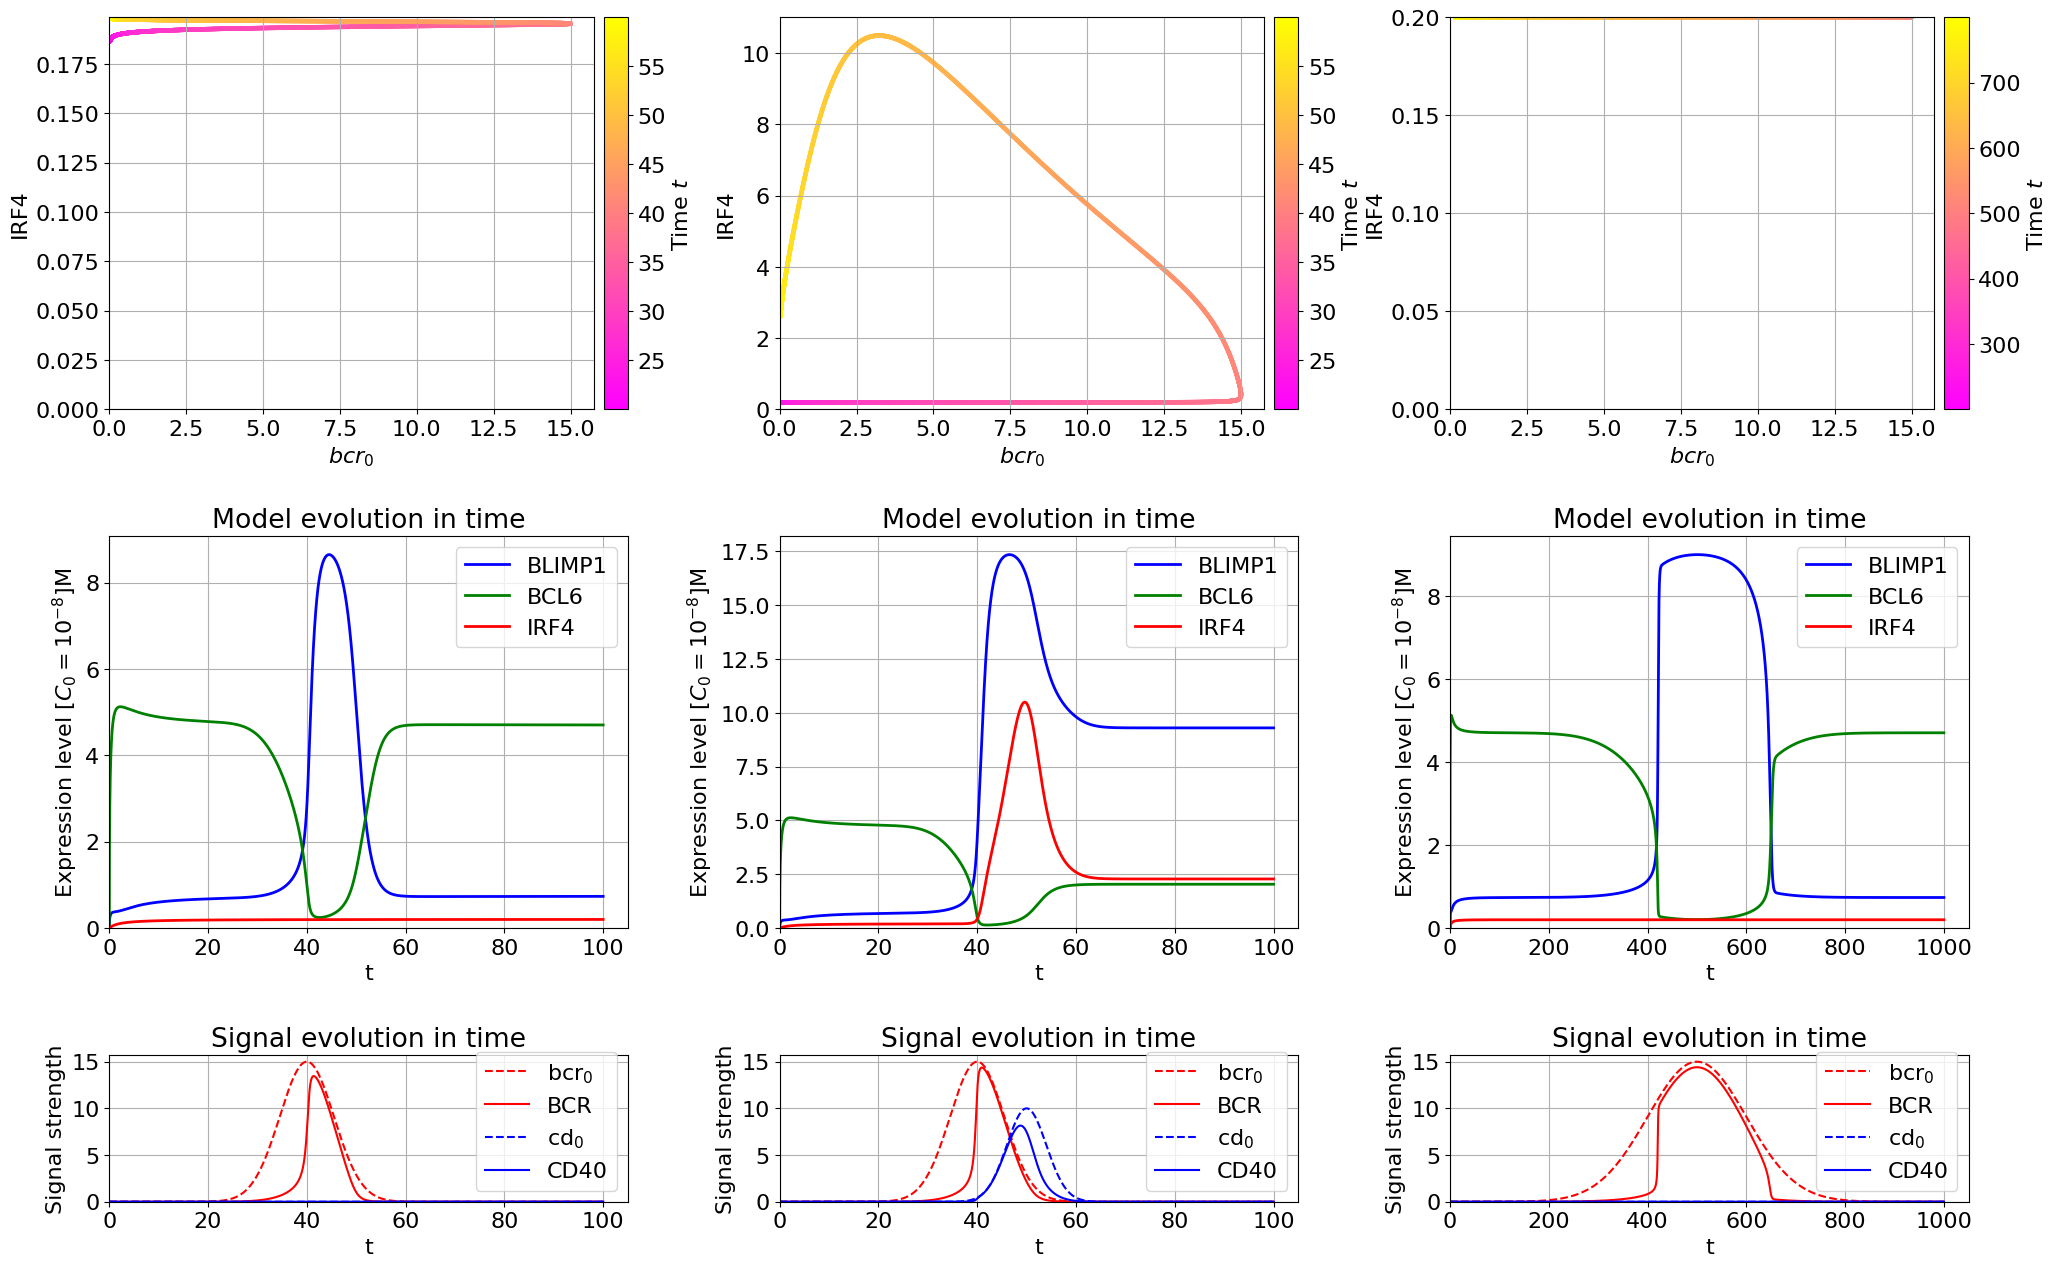

In [29]:
plt.rcParams.update({'font.size': 16})

# Solutions and plotting
fig, ax = plt.subplots(3,3,figsize=(21,14),height_ratios=[2,2,0.75])
fig.tight_layout(pad=4.0)

# --- Case 1: No CD40 signalling, reversible behaviour ---
t = np.linspace(0, 100, 10000)
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
r, b = sol[:,2], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,0].scatter(bcr0[2000:-4000], r[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,0].grid()
ax[0,0].set_xlabel(r"$bcr_0$")
ax[0,0].set_ylabel("IRF4")
ax[0,0].set_xlim(0,)
ax[0,0].set_ylim(0,)
# ax[0,0].set_title("Reversible change in BLIMP1 level\nwithout CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,0], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,0], t, sol, k_b, bcrt, cdt)
ax[2,0].set_ylim(0,)
ax[2,0].set_xlim(0,)
ax[2,0].set_yticks([0,5,10,15])

# --- Case 2: With CD40 signalling, irreversible behaviour ---
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=10, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
r, b = sol[:,2], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,1].scatter(bcr0[2000:-4000], r[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,1].grid()
ax[0,1].set_xlabel(r"$bcr_0$")
ax[0,1].set_ylabel("IRF4")
ax[0,1].set_xlim(0,)
ax[0,1].set_ylim(0,)
# ax[0,1].set_title("Irreversible change in BLIMP1\nwith CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,1], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,1], t, sol, k_b, bcrt, cdt)
ax[2,1].set_xlim(0,)
ax[2,1].set_ylim(0,)
ax[2,1].set_yticks([0,5,10,15])

# --- Case 3: Proper hysteresis (?) ---
t = np.linspace(0, 1000, 10000)

bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=500, scale=100)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
r, b = sol[:,2], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,2].scatter(bcr0[2000:-2000], r[2000:-2000], s=5, c=t[2000:-2000], cmap="spring")
ax[0,2].grid()
ax[0,2].set_xlabel(r"$bcr_0$")
ax[0,2].set_ylabel("IRF4")
ax[0,2].set_xlim(0,)
ax[0,2].set_ylim(0,)
# ax[0,2].set_title("Proper hysteresis when \nBCR signal is massively widened (?)", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,2], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,2], t, sol, k_b, bcrt, cdt)
ax[2,2].set_ylim(0,)
ax[2,2].set_xlim(0,)
ax[2,2].set_yticks([0,5,10,15])

plt.show()

As could be predicted from the general model dynamics, it does not. It will with CD40 on the $x$-axis though !

#### Hysteresis curve for BCL6

In [1]:
from scipy.optimize import fsolve

In [26]:
# BLIMP1 nullcline as given in the equation above
def dpdt_nullcline(b, kb, mp, sp, lp):
    return (mp + sp * ((kb**2) / (kb**2 + b**2))) / lp

# BCL6 nullcline as given in the equation above
def dbdt_nullcline(b,  kb, kp, mb, sb, lb, bcr0):
    BCR = bcr0 * ((kb**2) / (kb**2 + b**2))
    return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)

In [3]:
def find_roots(func, xmin, xmax, dx):
    roots = np.array([])
    xs = np.arange(start=xmin, stop=xmax, step=dx)
    for x in xs:
        r = fsolve(func, [x])
        if np.isclose(func(r), 0) and not np.count_nonzero(np.isclose(roots, r)):
            roots = np.append(roots, r)
    return roots

In [30]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

In [19]:
plt.rcParams.update({'font.size': 18})

C:\Users\User23718901\AppData\Local\Temp\ipykernel_11156\2921402822.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)
C:\Users\User23718901\AppData\Local\Temp\ipykernel_11156\1133576642.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  r = fsolve(func, [x])
C:\Users\User23718901\AppData\Local\Temp\ipykernel_11156\2921402822.py:8: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)
C:\Users\User23718901\AppData\Local\Temp\ipykernel_11156\1133576642.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  r = fsolve(func, [x])


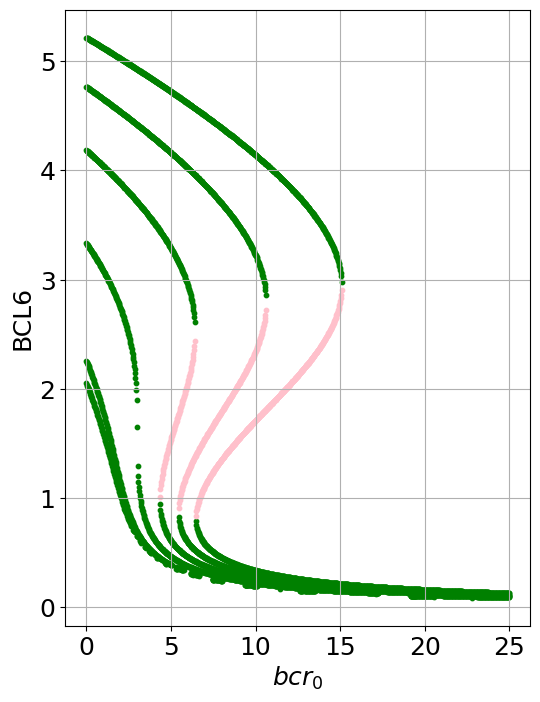

In [34]:
bmin, bmax, bstep = 0, 5, 0.05
bcrs = np.linspace(0, 25, 1000)
sigma_bs = [1, 5, 25, 50, 75, 100]

fig, ax = plt.subplots(1,1,figsize=(6,8))
ax.set_xlabel(r"$bcr_0$")
ax.set_ylabel("BCL6")
ax.grid()

for sigma_b in sigma_bs:
    for bcr0 in bcrs:
        dpdt0 = lambda b : dpdt_nullcline(b, k_b, mu_p, sigma_p, lam_p)
        dbdt0 = lambda b : dbdt_nullcline(b, k_b, k_p, mu_b, sigma_b, lam_b, bcr0)
        rootfunc = lambda b : dpdt0(b) - dbdt0(b)

        roots = find_roots(rootfunc, bmin, bmax, bstep)
        roots = sorted(roots)
        
        for (i, root) in enumerate(roots):
            if (i == 1 and len(roots) == 3):
                ax.scatter(bcr0, root, color="pink", s=10)
            else:
                ax.scatter(bcr0, root, color="green", s=10)

plt.show()

## Hysteretic behaviour of IRF4

In [30]:
# Time steps
t = np.linspace(0, 100, 10000)

# Initial condition
r0 = 0.0

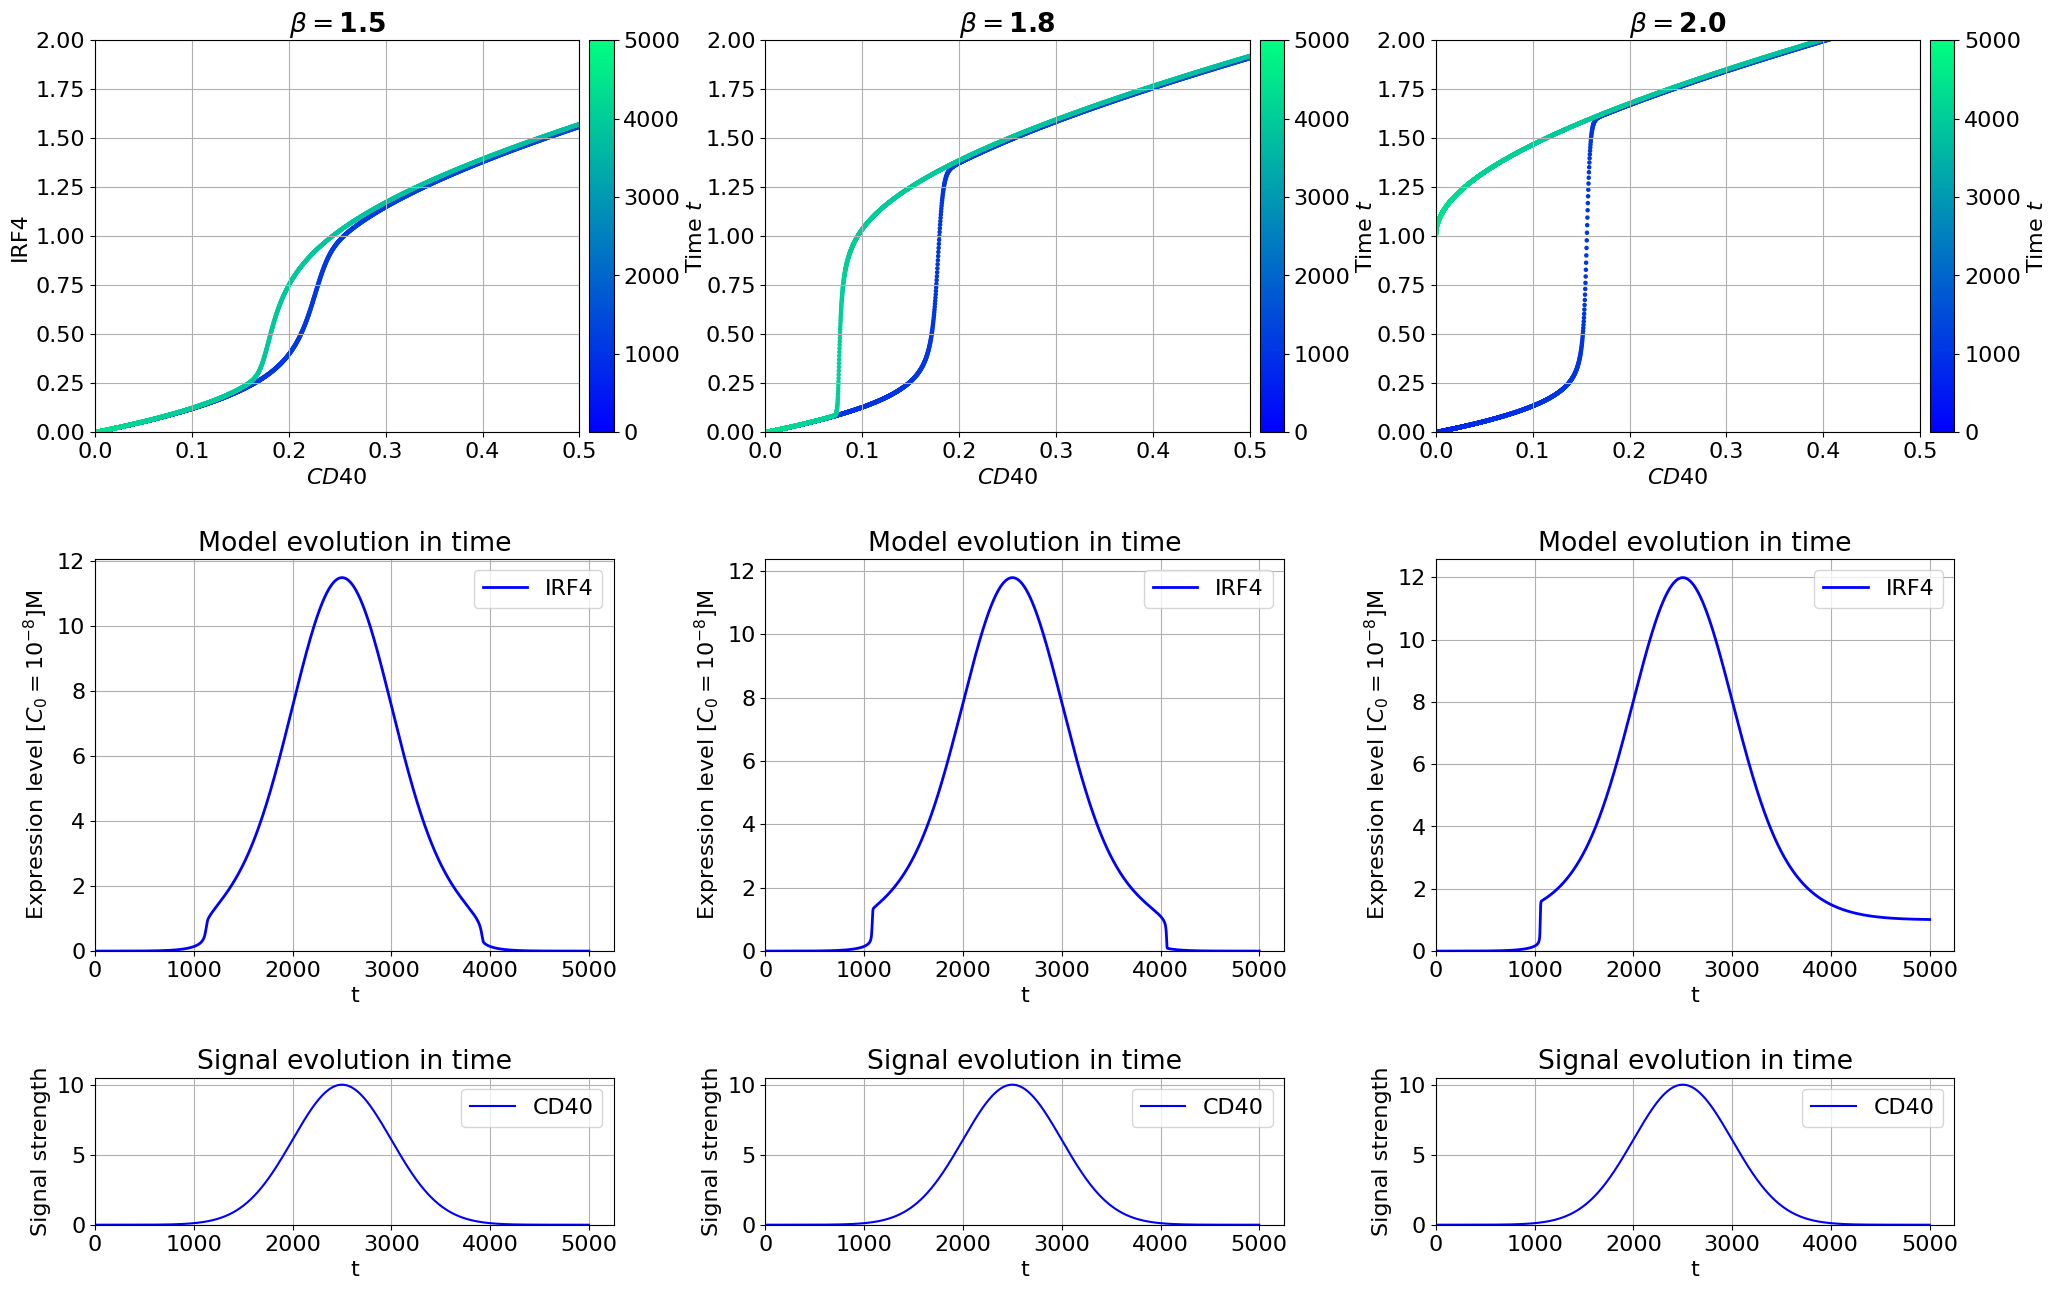

In [31]:
plt.rcParams.update({'font.size': 16})

# Solutions and plotting
fig, ax = plt.subplots(3,3,figsize=(21,14),height_ratios=[2,2,0.75])
fig.tight_layout(pad=4.0)

# --- CASE 1: Beta = 1.5 ---
mu_r = 0.00
sigma_r = 1.5
k_r = 1
lam_r = 1

cd0_strength = 10
t = np.linspace(0, 5000, 20000)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=cd0_strength, loc=2500, scale=500)

sol = CDSUB.solve_model(r0, t, k_r, sigma_r, mu_r, lam_r, cdt)
r = sol[:, 0]

cd0 = cdt(t)
# CD40 = cd0 * ((k_b**2) / (k_b**2 + b**2))

# Beta calculation
beta = (mu_r + 0 + sigma_r) / (lam_r * k_r)

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,0].scatter(cd0, r, s=5, c=t, cmap="winter")
ax[0,0].grid()
ax[0,0].set_xlabel(r"$CD40$")
ax[0,0].set_ylabel("IRF4")
ax[0,0].set_xlim(0,0.5)
ax[0,0].set_ylim(0,2.0)
ax[0,0].set_title(r"$\beta = $" + f"{beta}", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# # Model dynamics
CDSUB.plot_model(ax[1,0], t, sol)

# Signal plot
CDSUB.plot_signals(ax[2,0], t, cdt)
ax[2,0].set_ylim(0,)
ax[2,0].set_xlim(0,)

# --- CASE 2: Beta = 1.8 ---
mu_r = 0.00
sigma_r = 1.8
k_r = 1
lam_r = 1

sol = CDSUB.solve_model(r0, t, k_r, sigma_r, mu_r, lam_r, cdt)
r = sol[:, 0]

cd0 = cdt(t)
# CD40 = cd0 * ((k_b**2) / (k_b**2 + b**2))

# Beta calculation
beta = (mu_r + 0 + sigma_r) / (lam_r * k_r)

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,1].scatter(cd0, r, s=5, c=t, cmap="winter")
ax[0,1].grid()
ax[0,1].set_xlabel(r"$CD40$")
# ax[0,1].set_ylabel("IRF4")
ax[0,1].set_xlim(0,0.5)
ax[0,1].set_ylim(0,2.0)
ax[0,1].set_title(r"$\beta = $" + f"{beta}", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# # Model dynamics
CDSUB.plot_model(ax[1,1], t, sol)

# Signal plot
CDSUB.plot_signals(ax[2,1], t, cdt)
ax[2,1].set_ylim(0,)
ax[2,1].set_xlim(0,)


# --- CASE 3: Beta = 2 ---
mu_r = 0.00
sigma_r = 2.0
k_r = 1
lam_r = 1

sol = CDSUB.solve_model(r0, t, k_r, sigma_r, mu_r, lam_r, cdt)
r = sol[:, 0]

cd0 = cdt(t)
# CD40 = cd0 * ((k_b**2) / (k_b**2 + b**2))

# Beta calculation
beta = (mu_r + 0 + sigma_r) / (lam_r * k_r)

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,2].scatter(cd0, r, s=5, c=t, cmap="winter")
ax[0,2].grid()
ax[0,2].set_xlabel(r"$CD40$")
# ax[0,2].set_ylabel("IRF4")
ax[0,2].set_xlim(0,0.5)
ax[0,2].set_ylim(0,2.0)
ax[0,2].set_title(r"$\beta = $" + f"{beta}", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# # Model dynamics
CDSUB.plot_model(ax[1,2], t, sol)

# Signal plot
CDSUB.plot_signals(ax[2,2], t, cdt)
ax[2,2].set_ylim(0,)
ax[2,2].set_xlim(0,)

plt.show()

* No IRF4 production $\implies \mu_r = 0$
* Since "BCL6 is downregulated and repression is abbrogated" we get $CD40 = cd_0$
* I set $CD40$ term in $\beta$ to $0$. I really don't know what the hell it means, but since they mention $"\mu_r + CD40$ is approximately constant in early response" and the condition is $\beta > \sqrt{3}$, setting $CD40$ to $0$ is a **sufficient** bistability condition.
* Again used really really widened CD40 signal. Perhaps my understanding of the time unit is wrong.
* $k_r = 1$, $\lambda_r = 1$, so only $\sigma_r$ is varied. In fact $\beta = \sigma_r$ for the examples above.

$$ cd_0(t) $$

$\beta \in [ 1.8, 2.0 ]$ works fine, $\beta = 1.5$ not quite ?

## Parameter estimation

We are given (2 x 3) dataset (two of them, actually) for steady-state genetic expressions of $p, b, r$ (BLIMP1, BCL6, IRF4) of plasma-cells and GC B-cells. There are too many parameters to estimate for too little data points, so some of the parameters are set to $1$ through unit manipulation (all $k$ s and $\lambda$ s). Steady-state means we set equations $S1, S2, S3$ all to $0$. For plasma-cells, there is no BCR and CD40 signalling anymore, so we can make the following assumption:

$$ BCR  = 0 \;\; \land \;\; CD40 = 0 $$

Plugging all this information in for plasma-cells yields:

$$
\begin{align*}
    \frac{dp}{dt} &= \mu_p + \sigma_p \frac{1}{1 + b^2} + \sigma_p \frac{r^2}{1 + r^2} - p = 0 \\
    \frac{db}{dt} &= \mu_b + \sigma_b \frac{1}{1 + p^2} \cdot \frac{1}{1 + b^2} \cdot \frac{1}{1 + r^2} - b = 0 \\
    \frac{dr}{dt} &= \mu_r + \sigma_r \frac{r^2}{1 + r^2} - r = 0 \\
\end{align*}
$$